Build a baseline model using the weather station data (this approach used all days in 2018 since the data was available).


Then use the model to make predictions for the ENVI-met(micro-climate) data for that specific day and compare it to model predictions using weather station data also for the same day.

# 1. Import

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import pathlib
import pickle

import pathlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from datetime import datetime
from sklearn import metrics

#  for multicolinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor 

import PyQt5

# 2. Import Files

## 2.1 Save csv files as pickle

Only run this once to save our csv data as pickle files

In [ ]:
# --> NO NEED TO RUN SAVED AS PICKLE FILES <--
# WEATHER FILES ##

# # AZ PHX Sky Harbor Data #
# AZW_15 = pd.read_csv("./Data/Weather Data/KPHX-15.csv")

# # ENVIMET DATA #
# BPS = []
# Fname = []
# for path in pathlib.Path("./Data/BPS").iterdir():
#     if path.is_file():
#         current_file = pd.read_csv(path)
#         BPS.append(current_file)
#         Fname.append(path.name.replace('.csv', ''))

# # CAMPUS METABOLISM DATA #
# metabol14 = []
# for path in pathlib.Path('./Data/ASU 2018').iterdir():
#     if path.is_file():
#         current_file = pd.read_csv(path)
#         metabol14.append(current_file)

# ## Drop last row of EnviMet Data
# for i in range(len(BPS)):
#     BPS[i] = BPS[i].drop(16)

# ## Save files as pickle
# AZW_15.to_pickle("./Data/AZW_15.pkl")

# with open('./Data/BPS.pkl', 'wb') as f:
#     pickle.dump(BPS, f)

# with open('./Data/Fname.pkl', 'wb') as f:
#     pickle.dump(Fname, f)

# with open('./Data/metabol14.pkl', 'wb') as f:
#     pickle.dump(metabol14, f)

## 2.2 Reload Pickle

In [2]:
# We will convert these to df depending on the building we choose
# 2. Load 14 envimet bldgData (14 filtered buildings)
with open('./Data/BPS.pkl', 'rb') as f:
    envi14 = pickle.load(f)

# 3. Load names of BPS files
with open('./Data/Fname.pkl', 'rb') as f:
    Fname = pickle.load(f)

# 4. Load 14 campus metabolism building energy data
with open('./Data/metabol14.pkl', 'rb') as f:
    metabol14 = pickle.load(f)

## 2.3 Choose building name to import

In [3]:
##Print Building Names ##
for i in range(len(Fname)):
    print(Fname[i])
    
bldname = input('Enter building name: ')

for i in range(len(envi14)):
    if bldname == Fname[i]:
        # save 
        envi_bldg = envi14[i]

if bldname not in Fname:
    print("\x1b[31m\"Please enter a valid name from the list above\"\x1b[0m")


Health Services
Interdisciplinary AB
Bio Design Institute A
Lifescience A_B_D
Bio Design Institute B
COD North
Goldwater
University Club
Engineering Research Ctr
Best Hall
ISTB 1
ISTB 2
ISTB 4
ISTB 5


Enter building name:  University Club


## 2.4 Create Data Frame

In [4]:
class building:
    
    def __init__(self, bldgname):
        self.bldgname = bldgname
    
    def campusmetabolism(self):
        for i in range(len(metabol14)):
            if metabol14[i]['bldgname'][0] == bldname:
                cmp = metabol14[i]
            elif (metabol14[i]['bldgname'][0] == 'ISTB-5'):
                cmp = metabol14[i]
        return cmp
    
    def envimet(self):
        env = envi_bldg[['Date', 'Time', 'AirTempInFrontOfAllFacades_MEAN', 'RelativeAirHumidityInFrontOfAllFacades_MEAN',
                     'WindSpeedInFrontOfAllFacades_MEAN']]
        
        env = env.rename(columns = {'AirTempInFrontOfAllFacades_MEAN':'Air Temp',
                                    'RelativeAirHumidityInFrontOfAllFacades_MEAN':'Rel Humid',
                                    'WindSpeedInFrontOfAllFacades_MEAN':'Wind Speed'})
        return env


Bldg = building(bldname)
metabol = Bldg.campusmetabolism() # campus metabolism
envimet = Bldg.envimet()          # envimet
print(bldname)

University Club


In [5]:
# DF for AZ Weather Data (15-min)
weather_station = pd.read_pickle('./Data/AZW_15.pkl')

# 3. Preprocessing

## 3.1 Formatting Date and Time

### a) Envimet dates

In [6]:
# 1. format time
envimet['Time'] = envimet['Time'].str.replace('.',':')
envimet['Time'] = envimet['Time'].str.replace('01','00')

# convert to 24 hour format
envimet['Time'] = pd.to_datetime(envimet['Time']).dt.strftime('%H:%M')

# 2. format date (still in string)
envimet['Date'] = pd.to_datetime(envimet['Date']).dt.strftime('%m/%d/%Y')

# 3. combine date time column as string and set as index
envimet['Date_Time'] = envimet['Date'] + ' ' + envimet['Time']

# 4. Get string type for month and time
envimet['Month'] = envimet['Date_Time'].str[0:2]
envimet['Time'] = envimet['Time'].str.replace(':','')

# 5. Rearrange columns
print(list(envimet.columns))
envimet = envimet[['Date_Time','Month','Time', 'Air Temp', 'Rel Humid' ]]

envimet = envimet.set_index('Date_Time')


['Date', 'Time', 'Air Temp', 'Rel Humid', 'Wind Speed', 'Date_Time', 'Month']


<ipython-input-6-9e6431319558>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  envimet['Time'] = envimet['Time'].str.replace('.',':')


In [ ]:
# # 5. Get numeric for month hour and minute
# microclimate.Date_Time = pd.to_datetime(microclimate.Date_Time)
# microclimate['Month_num'] = microclimate.Date_Time.dt.month
# microclimate['Hour_num'] = microclimate.Date_Time.dt.hour
# microclimate['Minute_num'] = microclimate.Date_Time.dt.minute
# microclimate.Date_Time = pd.to_datetime(microclimate.Date_Time).dt.strftime('%m/%d/%Y %H:%M')

# # 6. Rearrange columns
# print(list(microclimate.columns))
# microclimate = microclimate[['Date_Time','Month','Time','Month_num', 'Hour_num', 'Minute_num', 'Air Temp', 'Rel Humid' ]]

### b) Weather Station dates

In [7]:
# 1. Get string type for month and time
weather_station['Month'] = weather_station['Date_Time'].str[0:2]
weather_station['Time'] = weather_station['Date_Time'].str[11:]
weather_station['Time'] = weather_station['Time'].str.replace(':','')

# 2. Get numeric for month hour and minute
weather_station.Date_Time = pd.to_datetime(weather_station.Date_Time)
weather_station['Month_num'] = weather_station.Date_Time.dt.month
weather_station['Hour_num'] = weather_station.Date_Time.dt.hour
weather_station['Minute_num'] = weather_station.Date_Time.dt.minute
weather_station.Date_Time = pd.to_datetime(weather_station.Date_Time).dt.strftime('%m/%d/%Y %H:%M')

# 3. set date time as index
weather_station = weather_station.set_index('Date_Time') 

### c) Building energy dates

In [8]:
metabol.tstamp = pd.to_datetime(metabol.tstamp).dt.strftime('%m/%d/%Y %H:%M')

# remove unwanted columns
metabol = metabol[['tstamp','KW', 'CHWTON']]

# set date time as index
metabol = metabol.set_index('tstamp')

## 3.2 Append Energy Consumption to Weather Station data

In [9]:
weather_station =  pd.concat([metabol, weather_station], axis = 1, join = "inner")

# rearrange column
weather_station = weather_station[['Month','Time','Month_num', 'Hour_num', 'Minute_num', 'Air Temp', 'Rel Humid', 'KW','CHWTON' ]]

# weather_station.to_csv('./Data/weather_st_numstr') # save data with string and numeric date format

In [10]:
weather_station.to_csv('./Data/weather_station_numstr') # save data with string and numeric date format


# 4. Create June 9th Data 

For both microclimate and weather_station

## 4.1 For Microclimate

We want: month, hour, minute, CHWTON, KW, date, air temp, and real humidity for microclimate June 9th.
We do this by merging with building_energy to get KW and CHWTON on the dates that appear in microclimate data



In [11]:
envimet_j9 = pd.merge(envimet, metabol, left_index = True, right_index = True)
envimet_j9

,Month,Time,Air Temp,Rel Humid,KW,CHWTON
06/09/2018 05:00,06,0500,29.537667,12.699708,27.60,11.80
06/09/2018 06:00,06,0600,29.033387,16.378229,29.52,10.88
06/09/2018 07:00,06,0700,29.604562,17.250977,25.46,11.27
06/09/2018 08:00,06,0800,31.459578,16.705515,26.53,13.98
06/09/2018 09:00,06,0900,33.820584,14.477529,25.99,14.48
06/09/2018 10:00,06,1000,35.796708,10.969304,25.55,14.76
06/09/2018 11:00,06,1100,36.879628,8.902718,26.89,16.36
06/09/2018 12:00,06,1200,37.837624,7.785688,26.19,17.59
06/09/2018 13:00,06,1300,38.771101,6.989491,26.26,17.81
06/09/2018 14:00,06,1400,39.486798,6.362558,25.39,18.37


## 4.2 For Weather Station

In [12]:
# 1. Convert to datetime so we can remove June 9th weather
weather_station.index = pd.to_datetime(weather_station.index)

# 2. Extract all of june 9th data 
station_j9 = weather_station[(weather_station.index.month == 6) & (weather_station.index.day == 9)]

# 3. drop all of June 9th from weather_station data
weather_station = weather_station.drop(station_j9.index)

# 4. Filter time ( only minute 00) from june 9th data
station_j9 = station_j9[ (station_j9['Hour_num'] >= 5) & (station_j9['Hour_num'] <= 20) & (station_j9['Minute_num'] == 0)]

# 5. drop numeric variables
weather_station = weather_station.drop(labels = ['Hour_num', 'Month_num','Minute_num'], axis = 1)
station_j9 = station_j9.drop(labels = ['Hour_num', 'Month_num','Minute_num'], axis = 1)

# 6. ensure theres no more june 9th data between 5am to 8pm on weather_station data
print(weather_station[(weather_station.index.month == 6) & (weather_station.index.day == 9)])

# 7. convert index back to string types
weather_station.index = pd.to_datetime(weather_station.index).strftime('%m/%d/%Y %H:%M')
station_j9.index = pd.to_datetime(station_j9.index).strftime('%m/%d/%Y %H:%M')
station_j9


Empty DataFrame
Columns: [Month, Time, Air Temp, Rel Humid, KW, CHWTON]
Index: []


,Month,Time,Air Temp,Rel Humid,KW,CHWTON
06/09/2018 05:00,06,0500,27.0,14.84,27.60,11.80
06/09/2018 06:00,06,0600,26.0,15.74,29.52,10.88
06/09/2018 07:00,06,0700,28.0,17.42,25.46,11.27
06/09/2018 08:00,06,0800,31.0,11.78,26.53,13.98
06/09/2018 09:00,06,0900,33.0,9.06,25.99,14.48
06/09/2018 10:00,06,1000,35.0,7.52,25.55,14.76
06/09/2018 11:00,06,1100,37.0,6.74,26.89,16.36
06/09/2018 12:00,06,1200,39.0,5.19,26.19,17.59
06/09/2018 13:00,06,1300,41.0,4.32,26.26,17.81
06/09/2018 14:00,06,1400,41.0,3.99,25.39,18.37


In [13]:
weather_station

,Month,Time,Air Temp,Rel Humid,KW,CHWTON
01/01/2018 00:00,01,0000,11.0,40.24,53.79,6.71
01/01/2018 00:15,01,0015,11.0,40.24,53.36,6.61
01/01/2018 00:30,01,0030,10.0,43.01,54.26,5.56
01/01/2018 00:45,01,0045,9.0,46.00,49.16,5.17
01/01/2018 01:00,01,0100,9.0,46.00,50.13,5.25
...,...,...,...,...,...,...
12/31/2018 22:00,12,2200,6.0,93.30,79.08,0.00
12/31/2018 22:15,12,2215,5.0,100.00,80.70,0.00
12/31/2018 22:30,12,2230,5.0,100.00,83.42,0.00
12/31/2018 22:45,12,2245,6.0,93.30,82.84,0.00


# 5. EDA

## 5.1 Correlation Matrix

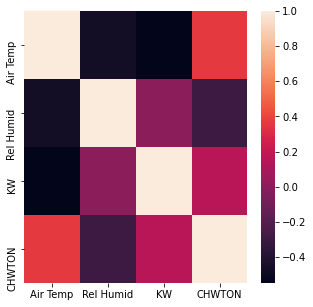

In [16]:
corrMatrix = weather_station.corr()
plt.figure(figsize=(5,5))
sns.heatmap(corrMatrix)
plt.show()

## 5.2 Multicolinearity

A simple method to detect multicollinearity in a model is by using something called the variance inflation factor or the VIF for each predicting variable. An acceptable VIF is if it’s less than the max of 10

In [15]:
## Get X and Y
Y = weather_station['CHWTON']
X = weather_station.drop(labels = ['CHWTON'], axis = 1)

X_int = X.drop(labels = ['Month', 'Time'], axis = 1)

vif_data = pd.DataFrame()
vif_data["feature"] = X_int.columns
vif_data["VIF"] = [variance_inflation_factor(X_int.values, i) for i in range(len(X_int.columns))]

vif_data

,feature,VIF
0,Air Temp,2.390765
1,Rel Humid,2.473726
2,KW,2.709856


# 6. Model 1: Random Forest

Scoring:
One one hand, RMSE tells us the typical distance between the predicted value made by the regression model and the actual value.

On the other hand, R2 tells us how well the predictor variables can explain the variation in the response variable.

## 6.1 Train Test (all year)

In [17]:
############################ RANDOM FORESTS #################################
# 1. Get train test 
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

# 2. Using RandomForestRegressor to make predictions
from sklearn.ensemble import RandomForestRegressor
# - string
base_RF = RandomForestRegressor(n_estimators=100, random_state=42)
base_RF.fit(X_train, Y_train)

# 3. Get prediction
Y_pred = base_RF.predict(X_test)
ModelPred = pd.DataFrame({'Actual CHWTON':Y_test, 'Predicted CHWTON':Y_pred})
ModelPred = ModelPred.sort_index()
print(ModelPred)

                  Actual CHWTON  Predicted CHWTON
01/01/2018 00:15           6.61            5.4285
01/01/2018 00:30           5.56            4.8669
01/01/2018 00:45           5.17            4.9070
01/01/2018 02:00           5.23            5.0892
01/01/2018 03:15           4.91            4.7833
...                         ...               ...
12/31/2018 15:00           0.00            0.0000
12/31/2018 16:00           0.00            0.0000
12/31/2018 17:30           0.00            0.0000
12/31/2018 19:45           0.00            0.0000
12/31/2018 23:00           0.00            0.0000

[6906 rows x 2 columns]


In [22]:
# 1. This function will returns R2 and RMSE score given a model and X, Y tests data
def evaluate(model, X_tests, Y_tests):
    Y_preds = model.predict(X_tests)
    R2 = model.score(X_tests, Y_tests)
    RMSE = np.sqrt(metrics.mean_squared_error(Y_tests, Y_preds))
    return [R2, RMSE]

# 2. This function will append a new all year score (row) to our scores data frame
def append_all_year_score(dataframe, score_list, model_name):
    i = dataframe.shape[0] # new index
    dataframe.loc[ i, 'model' ] = model_name
    dataframe.loc[ i, ('all_year','R2') ] = score_list[0]
    dataframe.loc[ i, ('all_year','RMSE') ] = score_list[1]
    return dataframe

# 3. This function will append a new June 9th score (column) to our scores data frame of the last row
def append_j9_score(dataframe, score_list, isEnvimet = False):
    data_name = 'weather_stn'
    if(isEnvimet == True):
        data_name = 'envimet'
        
    i = dataframe.shape[0] - 1 # last index
    dataframe.loc[i, (data_name, 'R2')] = score_list[0]
    dataframe.loc[i, (data_name, 'RMSE')] = score_list[1]

    return dataframe

In [23]:
# 1. get score
r2rmse = evaluate(base_RF, X_test, Y_test)

# 2. create score df
arrays = [["all_year", "all_year"],['R2', 'RMSE']]
tuples = list(zip(*arrays))
index = pd.MultiIndex.from_tuples(tuples)
scores_df = pd.DataFrame([[2,1]], columns=index)

# 3. fill model name and score
scores_df['model'] = 'base RF'
scores_df['all_year', 'R2'] = r2rmse[0]
scores_df['all_year', 'RMSE'] = r2rmse[1]
scores_df = scores_df[['model', 'all_year']]
scores_df

model  all_year          
                  R2      RMSE
0  base RF  0.960872  1.807081

In [24]:
# Feature importance
feature_list = list(X_train.columns)
feature_imp = pd.Series(base_RF.feature_importances_, index=feature_list).sort_values(ascending=False)
print("\033[1m" + "Feature Importances:" + "\033[0m")
print(feature_imp, "\n")


Feature Importances:
Air Temp     0.356173
Month        0.328557
KW           0.250880
Rel Humid    0.035904
Time         0.028486
dtype: float64 



## 6.2 June 9th Prediction

### Weather Station

In [25]:
# 1. Get X and Y (all test)
X_j9 = station_j9.drop(labels = ['CHWTON'], axis = 1)
Y_j9 = station_j9['CHWTON']

# 2. calc scores 
base_score = evaluate(base_RF, X_j9, Y_j9)

# 3. insert scores to scores_df row 0 to 1
scores_df = append_j9_score(scores_df, score_list, isEnvimet = False)

### Microclimate

In [30]:
# 1. Get X and Y (all test)
X_j9_envi = envimet_j9 .drop(labels = ['CHWTON'], axis = 1)

# 2. calc scores 
base_score = evaluate(base_RF, X_j9_envi, Y_j9)

# 3. insert scores to scores_df row 0 to 1
scores_df = append_j9_score(scores_df, base_score, isEnvimet = True)
scores_df

model  all_year           weather_stn            envimet          
                  R2      RMSE          R2     RMSE        R2      RMSE
0  base RF  0.960872  1.807081    0.587526  1.99748  0.763157  1.513612

# 7. Model 2: RF using random search

## 7.1 Set parameters grid

In [28]:
from sklearn.model_selection import RandomizedSearchCV

# 1. Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]

# 2. Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# 3. Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# 4. Minimum number of samples required at each leaf node
min_samples_leaf = [ 1, 2, 4]

# 5. Method of selecting samples for training each tree
bootstrap = [True, False]

# 6. Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


## 7.2 Train and score

In [29]:
# Use the random grid to search for best hyperparameters
# 1.Create the base model to tune
rf = RandomForestRegressor(random_state=42)

# 2. Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 20, cv = 5,
                               verbose = 2,
                               scoring ='r2',
                               random_state = 42,
                               n_jobs = -1)

# 3. Fit the random search model
rf_random.fit(X_train, Y_train)

# 4. print winning set of hyperparameters
from pprint import pprint
pprint(rf_random.best_estimator_.get_params())
pprint(rf_random.best_score_)

# 5. get the best model
random_RF = rf_random.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 20,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}
0.9641981329205261


In [35]:
# 6. get score
random_rf_score = evaluate(random_RF, X_test, Y_test, random = True)

# 7. insert score (row) to df
scores_df = append_all_year_score(scores_df, random_rf_score , 'random RF')


## 7.3 June 9th Prediction

### Weather Station

In [36]:
# 1. calc scores 
random_score = evaluate(random_RF, X_j9, Y_j9)

# 2. insert scores to scores_df row 0 to 1
scores_df = append_j9_score(scores_df, random_score, isEnvimet = False)


### Envimet

In [37]:
# 1. calc scores 
random_score = evaluate(random_RF, X_j9_envi, Y_j9)

# 3. insert scores to scores_df row 0 to 1
scores_df = append_j9_score(scores_df, random_score, isEnvimet = True)
scores_df

model  all_year           weather_stn             envimet          
                    R2      RMSE          R2      RMSE        R2      RMSE
0    base RF  0.960872  1.807081    0.587526  1.997480  0.763157  1.513612
1  random RF  0.962543  1.768080    0.575289  2.026894  0.893747  1.013806

# 8. Model 3: LGBM

## 8.1 Grid Search

In [ ]:
import catboost as cb
catboost = cb.CatBoostRegressor(loss_function='RMSE')
grid = {'iterations': [50, 100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 8, 10],
        'l2_leaf_reg': [0.2, 0.5, 1, 3, 5]}


train_dataset = cb.Pool(X_train, Y_train) 
test_dataset = cb.Pool(X_test, Y_test)
result = catboost.grid_search(grid,
                           train_dataset,
                           cv = 5,
                           search_by_train_test_split=True,
                           shuffle = True,
                           refit=True,
                           verbose = True,
                           train_size=0.8 )



0:	learn: 12.0986056	test: 11.9312771	best: 11.9312771 (0)	total: 5.16ms	remaining: 253ms
1:	learn: 11.8488287	test: 11.6833718	best: 11.6833718 (1)	total: 9.4ms	remaining: 226ms
2:	learn: 11.6078179	test: 11.4409607	best: 11.4409607 (2)	total: 11.5ms	remaining: 181ms
3:	learn: 11.3754443	test: 11.2093440	best: 11.2093440 (3)	total: 13.8ms	remaining: 159ms
4:	learn: 11.1505740	test: 10.9852547	best: 10.9852547 (4)	total: 16.1ms	remaining: 145ms
5:	learn: 10.9367198	test: 10.7721228	best: 10.7721228 (5)	total: 18.6ms	remaining: 136ms
6:	learn: 10.7361913	test: 10.5706996	best: 10.5706996 (6)	total: 20.8ms	remaining: 128ms
7:	learn: 10.5371023	test: 10.3715382	best: 10.3715382 (7)	total: 24ms	remaining: 126ms
8:	learn: 10.3484492	test: 10.1842189	best: 10.1842189 (8)	total: 28.3ms	remaining: 129ms
9:	learn: 10.1625434	test: 9.9999864	best: 9.9999864 (9)	total: 31.8ms	remaining: 127ms
10:	learn: 9.9859904	test: 9.8254503	best: 9.8254503 (10)	total: 34.1ms	remaining: 121ms
11:	learn: 9.821

In [ ]:
result['params']

In [99]:
catboost = cb.CatBoostRegressor(depth= 10, l2_leaf_reg = 0.5, iterations = 200, learning_rate= 0.1)
catboost.fit(train_dataset)

0:	learn: 8.4738122	total: 116ms	remaining: 28.9s
1:	learn: 7.7474719	total: 205ms	remaining: 25.4s
2:	learn: 7.1093166	total: 278ms	remaining: 22.9s
3:	learn: 6.5386805	total: 367ms	remaining: 22.6s
4:	learn: 6.0284955	total: 442ms	remaining: 21.7s
5:	learn: 5.5728492	total: 512ms	remaining: 20.8s
6:	learn: 5.1673854	total: 586ms	remaining: 20.4s
7:	learn: 4.8138399	total: 662ms	remaining: 20s
8:	learn: 4.4934889	total: 736ms	remaining: 19.7s
9:	learn: 4.2205979	total: 820ms	remaining: 19.7s
10:	learn: 3.9787930	total: 913ms	remaining: 19.8s
11:	learn: 3.7594147	total: 1.08s	remaining: 21.4s
12:	learn: 3.5720042	total: 1.18s	remaining: 21.5s
13:	learn: 3.4019092	total: 1.27s	remaining: 21.5s
14:	learn: 3.2545527	total: 1.38s	remaining: 21.7s
15:	learn: 3.1322404	total: 1.46s	remaining: 21.4s
16:	learn: 3.0232904	total: 1.56s	remaining: 21.4s
17:	learn: 2.9243479	total: 1.64s	remaining: 21.2s
18:	learn: 2.8403232	total: 1.72s	remaining: 20.9s
19:	learn: 2.7674827	total: 1.8s	remaining:

In [100]:
# 6. get score
catboost_score = evaluate(catboost, X_test, Y_test)

# 7. insert score (row) to df
scores_df = append_all_year_score(scores_df, catboost_score , 'catboost')

In [101]:
scores_df 

model  all_year           weather_stn             envimet          
                    R2      RMSE          R2      RMSE        R2      RMSE
0    base RF  0.960872  1.807081    0.587526  1.997480  0.763157  1.513612
1  random RF  0.962543  1.768080    0.575289  2.026894  0.893747  1.013806
2   catboost  0.948967  2.063771    0.783238  1.448024  0.781198  1.454823
3   catboost  0.937850  2.277489         NaN       NaN       NaN       NaN
4   catboost  0.943990  2.162062         NaN       NaN       NaN       NaN
5   catboost  0.948338  2.076453         NaN       NaN       NaN       NaN
6   catboost  0.954979  1.938387    0.703918  1.692351  0.856938  1.176375
7   catboost  0.955209  1.933436    0.814503  1.339531  0.735367  1.599949
8   catboost  0.961201  1.799464         NaN       NaN       NaN       NaN

## 8.2 June 9th Prediction

### Weather Station

In [102]:
# 1. calc scores 
cb_score = evaluate(catboost, X_j9, Y_j9)

# 2. insert scores to scores_df row 0 to 1
scores_df = append_j9_score(
scores_df, cb_score, isEnvimet = False)

### Envimet

In [103]:
#1. calc scores 
cb_score = evaluate(catboost, X_j9_envi, Y_j9)

# 3. insert scores to scores_df row 0 to 1
scores_df = append_j9_score(scores_df, cb_score, isEnvimet = True)
scores_df

model  all_year           weather_stn             envimet          
                    R2      RMSE          R2      RMSE        R2      RMSE
0    base RF  0.960872  1.807081    0.587526  1.997480  0.763157  1.513612
1  random RF  0.962543  1.768080    0.575289  2.026894  0.893747  1.013806
2   catboost  0.948967  2.063771    0.783238  1.448024  0.781198  1.454823
3   catboost  0.937850  2.277489         NaN       NaN       NaN       NaN
4   catboost  0.943990  2.162062         NaN       NaN       NaN       NaN
5   catboost  0.948338  2.076453         NaN       NaN       NaN       NaN
6   catboost  0.954979  1.938387    0.703918  1.692351  0.856938  1.176375
7   catboost  0.955209  1.933436    0.814503  1.339531  0.735367  1.599949
8   catboost  0.961201  1.799464    0.665803  1.797984  0.637937  1.871441

In [ ]:
Pred = pd.DataFrame({'Actual':Y_actual_j9,'Baseline Predictions (AZW)': Y_pred_j9, 'Microclimate Predictions': Y_pred_j9_envi})
Pred

# 10. Hypothesis Test

In [ ]:
plt.boxplot([Y_pred_j9, Y_pred_j9_envi])
plt.xticks([1,2],['Baseline_pred', 'Microclimate_pred'])
print(Y_pred_j9.mean())
print(Y_pred_j9_envi.mean())
print('mu:', Y_pred_j9.mean()- Y_pred_j9_envi.mean())

# Two-Sample T Test


mean differences in CHWTON = $ \mu_{baseline} - \mu_{microclimate}$ 

$ H_0: $ Mean of CHWTON in baseline and microclimate are the same

$ H_1: $ Mean of CHWTON in baseline and microclimate are NOT the same

## 10.1 calculate standard deviation

In [ ]:
# 1.variance
var_baseline = Y_pred_j9.var(ddof = 1)
var_micro = Y_pred_j9_envi.var(ddof = 1)
print('var:',var_baseline, var_micro)

# 2. standard deviation
s = np.sqrt((var_baseline + var_micro)/2)
print('s:',s)

## 10.2 calculate T-statistic

In [ ]:
import scipy.stats as stats
t_stat, p_val = stats.ttest_ind(Y_pred_j9, Y_pred_j9_envi, equal_var=False)
print('t statistics: ', t_stat)
print('p value: ', p_val)

P value is not less that 0.05. We cannot reject the null hypothesis. There is no significant difference between the transaction amount of fraud and non fraudulent transaction

# 11. Plot

In [ ]:
####### Plotting Baseline Model for all 2018 15-min Data #######

## This is a big graph, will be slow to run but gives visual of prediction accuracy
# %matplotlib qt
plt.xlabel('Baseline 15-Min Model')
plt.ylabel('CHWTON')
plt.plot(ModelPred['Actual CHWTON'], label = 'Actual CHWT')
plt.plot(ModelPred['Predicted CHWTON'], label = 'Predicted CHWT')
plt.legend()
plt.show()

In [ ]:
#  Plotting ENVI-met vs AZW vs Actual Data for June 9 from 5a - 8p

positions = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
labels = ['5a', '6a', '7a', '8a', '9a', '10a', '11a', '12p', '1p', '2p', '3p', '4p', '5p', '6p', '7p', '8p']

# plot EnviMet vs AZ_Weather results
plt.xlabel('Time 5a - 8p')
plt.ylabel('CHWTON')
plt.xticks(positions, labels)
plt.plot(Pred['Microclimate Predictions'], label = 'ENVIMET Weather')
plt.plot(Pred['Baseline Predictions (AZW)'], label = 'Baseline Weather (AZW)')
plt.plot(Pred['Actual'], label = 'Actual Data')
plt.title(bldname)
plt.legend()

## show graphs
plt.show()

# 12. Save DF

## 12.1 Weather Station string


In [ ]:
weather_station.to_csv('./Data/weather_st_string')

## 12.2 June 9th Weather St


In [ ]:
weather_st_June_9.to_csv('./Data/weather_AZ_j9')

In [ ]:
# scores_df.to_csv('./Data/score')